# Model #2a ‚Äì pou≈æit√≠ klasick√Ωch metod poƒç√≠taƒçov√©ho vidƒõn√≠ s pevnou m≈ô√≠≈ækou

Tento model slou≈æ√≠ k automatick√©mu rozpozn√°n√≠, zda je Rubikova kostka slo≈æen√°, nebo ne ‚Äì bez pou≈æit√≠ strojov√©ho uƒçen√≠ nebo tr√©novac√≠ch dat. M√≠sto toho spol√©h√° na p≈ôesn√© um√≠stƒõn√≠ kostky do p≈ôedem dan√© m≈ô√≠≈æky, kde jsou analyzov√°ny barevn√© oblasti.
> Pozn√°mka: Neprov√°d√≠ ≈æ√°dn√© odstranƒõn√≠ pozad√≠ ani detekci samotn√© kostky v obraze. Cel√Ω vstup mus√≠ b√Ωt spr√°vnƒõ zarovnan√Ω u≈æ p≈ôi focen√≠.

---

## Kalibrace barev
Na zaƒç√°tku prob√≠h√° kalibrace barev, kde u≈æivatel um√≠st√≠ Rubikovu kostku tak, aby byla cel√° vidƒõt v p≈ôipraven√© m≈ô√≠≈æce (3√ó3). Program z ka≈æd√©ho obr√°zku z√≠sk√° barvu st≈ôedu (medi√°n oblasti st≈ôedu). T√≠m se p≈ôi≈ôad√≠ ≈°est konkr√©tn√≠ch barev: b√≠l√°, ≈ælut√°, zelen√°, modr√°, ƒçerven√°, oran≈æov√°.

<p align="left">
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/stickerless_kalibrace_white.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/stickerless_kalibrace_yellow.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/stickerless_kalibrace_green.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/stickerless_kalibrace_blue.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/stickerless_kalibrace_red.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/stickerless_kalibrace_orange.png?raw=true" width="200"/>
</p>

---

## Skenov√°n√≠ jednotliv√Ωch stran
Pot√© u≈æivatel postupnƒõ vyfot√≠ v≈°ech 6 stran kostky. U ka≈æd√©ho sn√≠mku
mus√≠ b√Ωt kostka opƒõt spr√°vnƒõ zarovn√°na do m≈ô√≠≈æky,
z√≠sk√° se 9 samolepek dan√© strany. K focen√≠ se pou≈æ√≠v√° klasick√° webkamera.

---

## Vyhodnocen√≠ slo≈æenosti
Program zkontroluje, zda ka≈æd√° ze ≈°esti stran obsahuje 9 samolepek stejn√© barvy. Pokud ano, je kostka pova≈æov√°na za slo≈æenou. Model nekontroluje barvy v≈Øƒçi sobƒõ, ani netvo≈ô√≠ 3D reprezentaci cel√© kostky.

---

---

# Importy

In [ ]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from pathlib import Path
from PIL import Image

import io
import html
import time
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# JavaScriptov√© funkce

In [ ]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      video.setAttribute('playsinline', '');
      video.style.position = 'relative';

      const canvas = document.createElement('canvas');
      canvas.style.position = 'absolute';
      canvas.style.top = '0';
      canvas.style.left = '0';

      const container = document.createElement('div');
      container.style.position = 'relative';
      container.appendChild(video);
      container.appendChild(canvas);

      div.appendChild(container);
      document.body.appendChild(div);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      // Synchronizace velikost√≠
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;

      const ctx = canvas.getContext('2d');

      // Kreslen√≠ m≈ô√≠≈æky v loopu
      function drawGrid() {
          ctx.clearRect(0, 0, canvas.width, canvas.height);
          ctx.strokeStyle = 'rgba(255, 0, 0, 0.9)';
          ctx.lineWidth = 2;

          const gridSize = 3; // 3x3 m≈ô√≠≈æka
          const totalBoxSize = 240; // Zabere 50 % ≈°√≠≈ôky pl√°tna
          const cellSize = totalBoxSize / gridSize;

          const startX = (canvas.width - totalBoxSize) / 2;
          const startY = (canvas.height - totalBoxSize) / 2;

          for (let row = 0; row < gridSize; row++) {
            for (let col = 0; col < gridSize; col++) {
              const x = startX + col * cellSize;
              const y = startY + row * cellSize;
              ctx.strokeRect(x, y, cellSize, cellSize);
            }
          }
      }

      drawGrid();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);

      const snapCanvas = document.createElement('canvas');
      const videoWidth = video.videoWidth;
      const videoHeight = video.videoHeight;
      const size = Math.min(videoWidth, videoHeight);
      const offsetX = (videoWidth - size) / 2;
      const offsetY = (videoHeight - size) / 2;
      snapCanvas.width = size;
      snapCanvas.height = size;

      const snapCtx = snapCanvas.getContext('2d');
      snapCtx.drawImage(video, offsetX, offsetY, size, size, 0, 0, size, size);

      stream.getVideoTracks()[0].stop();
      div.remove();

      return snapCanvas.toDataURL('image/jpeg', quality);
    }
  ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))

  # convert to OpenCV image
  img = np.asarray(js_to_image(data))

  # optional saving
  cv2.imwrite(filename, img)
  return img

# Funkce pro kalibraci kamery

In [ ]:
def get_average_hsv(region, color):
    """V√Ωpoƒçet pr≈Ømƒõrn√© hodnoty HSV z t√©to oblasti."""
    h = np.median(region[:, :, 0])
    s = np.median(region[:, :, 1])
    v = np.median(region[:, :, 2])

    return h, s, v

In [ ]:
def get_region(image):
    """Z√≠sk√° oblast m≈ô√≠≈æky."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    height, width, _ = image.shape
    center_x, center_y = width // 2, height // 2
    region_size = 30
    half_size = region_size // 2

    region = hsv[center_y - half_size : center_y + half_size, center_x - half_size : center_x + half_size]
    return region

In [ ]:
def show_calibrated_region(region):
    """Zobraz√≠ kalibrovan√Ω region."""
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_HSV2RGB))
    plt.title("Oblast kalibrace")
    plt.axis('off')
    plt.show()

# Kalibrace kamery

In [1]:
def calibrate_camera():
    """Zkalibruje postupnƒõ v≈°ech 6 barev Rubikovy kostky."""

    average_hue_arr = {}
    average_saturation_arr = {}
    average_value_arr = {}

    for color in COLORS:
        while True:
            print(f"Prob√≠h√° kalibrace barvy {color}...")
            image = take_photo()
            region = get_region(image)
            show_calibrated_region(region)

            h, s, v = get_average_hsv(region, color)

            average_hue_arr[color] = h
            average_saturation_arr[color] = s
            average_value_arr[color] = v

            choice = input(f"Jsi spokojen√Ω? (a = ano, jak√°koliv jin√° kl√°vesa = zopakovat fotku)").lower()
            if choice == 'a':
                break
            else:
                print(f"Opakuji kalibraci barvy {color}...")

    print(f"Kalibrace byla √∫spƒõ≈°nƒõ dokonƒçena.")

    return average_hue_arr, average_saturation_arr, average_value_arr

# D√≠lƒç√≠ funkce

In [ ]:
def get_grid_points(image, grid_size=3, box_fraction=0.5):
    """Z√≠sk√° body mezi hlavn√≠mi body m≈ô√≠≈æky."""
    H, W = image.shape[:2]

    totalBoxSize = box_fraction * min(W, H)  # velikost ƒçtverce
    startX = (W - totalBoxSize) / 2
    startY = (H - totalBoxSize) / 2

    step = totalBoxSize / grid_size  # vzd√°lenost mezi body

    points = []
    for i in range(grid_size + 1):
        row = []
        for j in range(grid_size + 1):
            x = startX + j * step
            y = startY + i * step
            row.append([x, y])
        points.append(row)

    return np.array(points)  # tvar (4,4,2)

In [ ]:
def show_grid_points(grid_points):
    """Zobraz√≠ v≈°ech 16 bod≈Ø m≈ô√≠≈æky na obr√°zku."""
    for row in grid_points:
        for (x, y) in row:
            cv2.circle(image, (int(x), int(y)), radius=5, color=(0, 0, 255), thickness=-1)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

In [ ]:
def average_color_in_quad(image, pts):
    """Vypoƒç√≠t√° pr≈Ømƒõrnou barvu ve zvolen√© oblasti."""
    # Vytvo≈ô√≠me masku polygonu
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [pts.astype(np.int32)], 255)

    # Najdeme v≈°echny pixely v masce
    masked_pixels = cv2.bitwise_and(image, image, mask=mask)

    # Spoƒç√≠t√°me pr≈Ømƒõr p≈ôes v≈°echny barevn√© kan√°ly
    mean_color = []
    for i in range(3):  # kan√°ly B,G,R
        channel_vals = masked_pixels[:, :, i][mask == 255]
        mean_val = np.median(channel_vals) if len(channel_vals) > 0 else 0
        mean_color.append(mean_val)

    return tuple(mean_color)

In [ ]:
def get_colors_matrix(image):
    """Na z√°kladƒõ z√≠sk√°n√≠ pr≈Ømƒõrn√© barvy v ka≈æd√© oblasti spoƒç√≠t√° celou matici barev (samolepek)."""
    colors_matrix = np.zeros((3, 3, 3))  # 3x3 pol√≠ƒçka, 3 barvy (B, G, R)

    for i in range(3):
        for j in range(3):
            # 4 body dan√©ho pol√≠ƒçka:
            quad = np.array([
                grid_points[i, j],
                grid_points[i, j+1],
                grid_points[i+1, j+1],
                grid_points[i+1, j]
            ])
            avg_col = average_color_in_quad(image, quad)
            colors_matrix[i, j] = avg_col
    return colors_matrix

In [ ]:
def bgr_to_hsv_pixel(bgr):
    """P≈ôev√°d√≠ barvu z bgr do hsv."""
    bgr_uint8 = np.uint8([[bgr]])  # mus√≠ b√Ωt uint8, tvar (1,1,3)
    hsv = cv2.cvtColor(bgr_uint8, cv2.COLOR_BGR2HSV)
    return hsv[0, 0]  # vrac√≠ [H, S, V]

In [ ]:
def find_closest_hsv_color(hsv_pixel, average_hue_arr, average_saturation_arr, average_value_arr, threshold=5):
    """Najde nejbli≈æ≈°√≠ barvu k dan√© barvƒõ z matice v hsv prostoru. Vyb√≠r√° z nakalibrovan√Ωch barev."""

    distances = []
    # Vypoƒç√≠t√°me referenƒçn√≠ hsv pro ka≈ædou barvu.
    for color in average_hue_arr.keys():
        ref_h = average_hue_arr[color]
        ref_s = average_saturation_arr[color]
        ref_v = average_value_arr[color]
        dist = np.linalg.norm(np.array(hsv_pixel) - np.array([ref_h, ref_s, ref_v]))
        distances.append((dist, color))

    # Se≈ôad√≠me podle vzd√°lenosti vzestupnƒõ
    distances.sort(key=lambda x: x[0])

    # Nejbli≈æ≈°√≠ a druh√° nejbli≈æ≈°√≠ vzd√°lenost
    min_dist, closest_color = distances[0]
    if len(distances) > 1:
        second_dist, _ = distances[1]
    else:
        second_dist = float('inf')

    # Pokud je minim√°ln√≠ vzd√°lenost vƒõt≈°√≠ ne≈æ threshold,
    # nebo pokud je rozd√≠l mezi prvn√≠ a druhou vzd√°lenost√≠ mal√Ω (nejistota),
    # pak vr√°t√≠me "nen√≠ mo≈æn√© urƒçit".
    if (second_dist - min_dist) < threshold:
        return "nen√≠ mo≈æn√© urƒçit"
    else:
        return closest_color

In [ ]:
def get_text_matrix(colors_matrix, average_hue_arr, average_saturation_arr, average_value_arr):
    """Z matice barev (bgr) z√≠sk√°me p≈ô√≠mo jednotliv√© barvy textovƒõ."""
    text_matrix = np.empty(colors_matrix.shape[:2], dtype=object)

    for i in range(colors_matrix.shape[0]):
        for j in range(colors_matrix.shape[1]):
            bgr_pixel = colors_matrix[i, j]
            hsv_pixel = bgr_to_hsv_pixel(bgr_pixel)
            # print(f"hsv_pixel: {hsv_pixel}")
            text_matrix[i, j] = find_closest_hsv_color(hsv_pixel, average_hue_arr, average_saturation_arr, average_value_arr)

    return text_matrix

In [ ]:
def is_solved_side(matrix):
    """Vr√°t√≠ True, pokud v≈°echny prvky v 3x3 matici jsou stejn√©."""
    first = matrix[0][0]
    for row in matrix:
        for cell in row:
            if cell != first:
                return False
    return True

## Definice barev
> Pozn√°mka: Vƒõt≈°ina Rubikov√Ωch kostek m√° tƒõchto 6 barev. [Western color scheme.](https://speedsolving.fandom.com/wiki/Western_Color_Scheme)

In [ ]:
COLORS = ['white', 'yellow', 'green', 'blue', 'red', 'orange']

# Vyzkou≈°ejte si model
Zde je mo≈ænost otestovat si n√°≈° model rovnou z va≈°√≠ webkamery. \
Nejprve je pot≈ôeba nakalibrovat jednotliv√© barvy, kalibrace prob√≠h√° z barvy samolepky, kterou um√≠st√≠te doprost≈ôed m≈ô√≠≈æky. Postupnƒõ tedy vyfot≈•e v≈°ech 6 barev. Po ka≈æd√©m vyfocen√≠ se m≈Ø≈æete rozhodnout, zda kalibraci potvrd√≠te (zm√°ƒçnut√≠m kl√°vesy a), nebo zopakujete (zm√°ƒçknut√≠m jak√©koliv jin√© kl√°vesy).

<IPython.core.display.Javascript object>

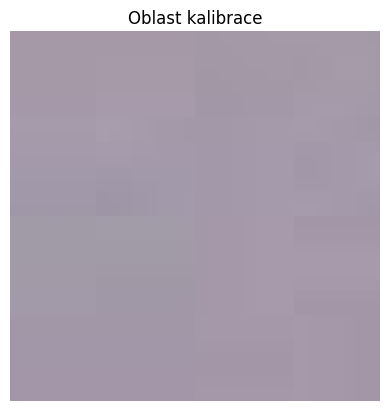

Jsi spokojen√Ω? (a = ano, jak√°koliv jin√° kl√°vesa = zopakovat fotku)a


<IPython.core.display.Javascript object>

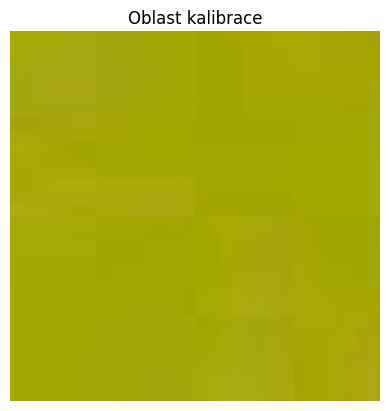

Jsi spokojen√Ω? (a = ano, jak√°koliv jin√° kl√°vesa = zopakovat fotku)a


<IPython.core.display.Javascript object>

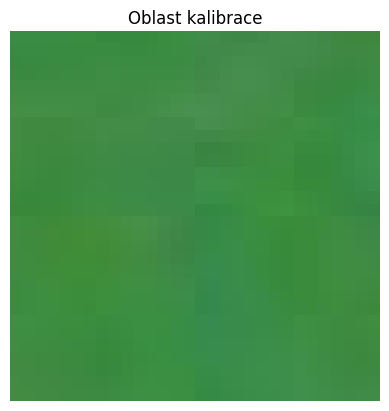

Jsi spokojen√Ω? (a = ano, jak√°koliv jin√° kl√°vesa = zopakovat fotku)a


<IPython.core.display.Javascript object>

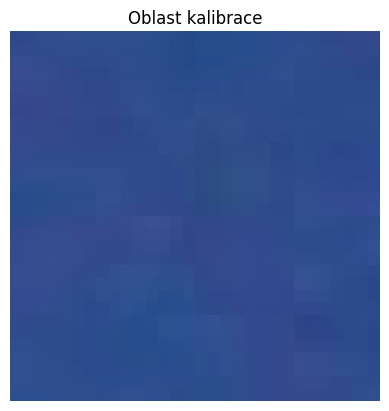

Jsi spokojen√Ω? (a = ano, jak√°koliv jin√° kl√°vesa = zopakovat fotku)a


<IPython.core.display.Javascript object>

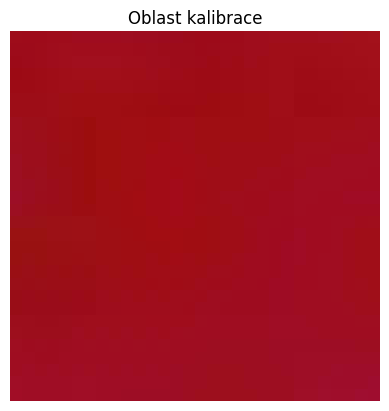

Jsi spokojen√Ω? (a = ano, jak√°koliv jin√° kl√°vesa = zopakovat fotku)a


<IPython.core.display.Javascript object>

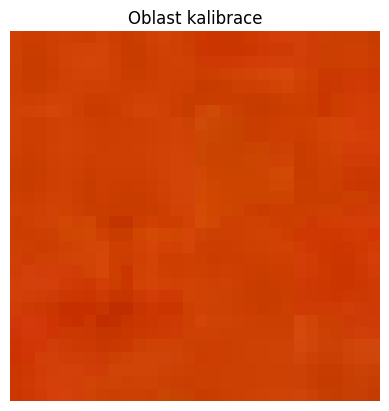

Jsi spokojen√Ω? (a = ano, jak√°koliv jin√° kl√°vesa = zopakovat fotku)a


<IPython.core.display.Javascript object>

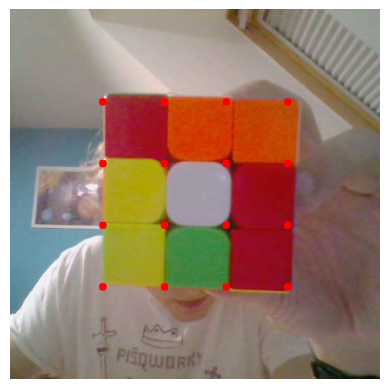

<IPython.core.display.Javascript object>

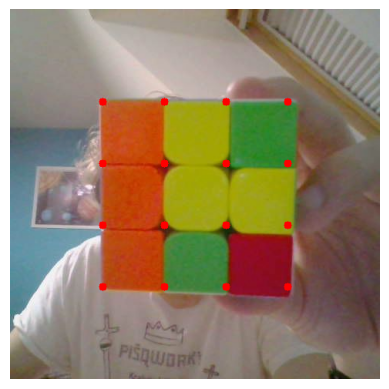

<IPython.core.display.Javascript object>

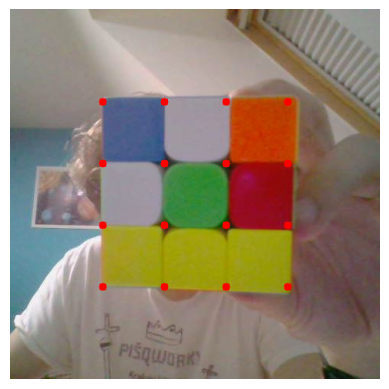

<IPython.core.display.Javascript object>

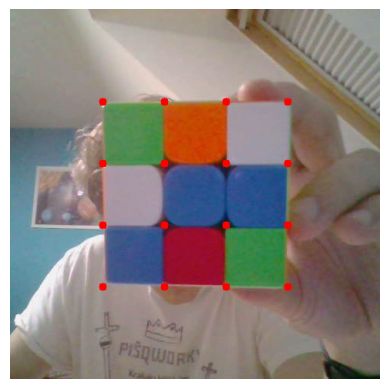

<IPython.core.display.Javascript object>

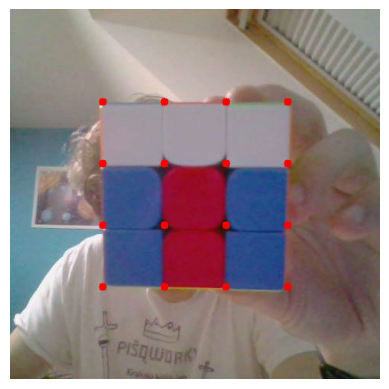

<IPython.core.display.Javascript object>

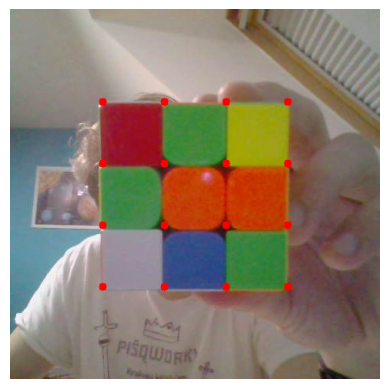

In [ ]:
# Kalibrace barev
average_hue_arr, average_saturation_arr, average_value_arr = calibrate_camera()

Vyfo≈•te postupnƒõ ≈°est stran Rubikovy kostky.

<IPython.core.display.Javascript object>

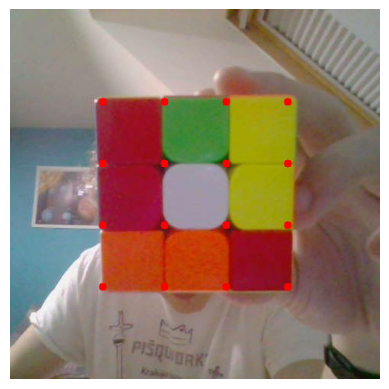

<IPython.core.display.Javascript object>

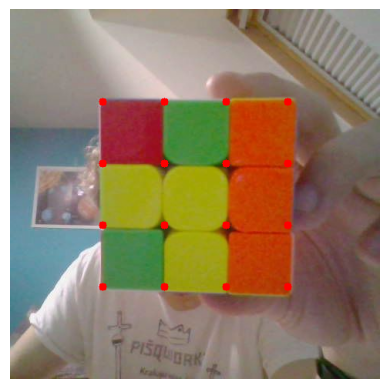

<IPython.core.display.Javascript object>

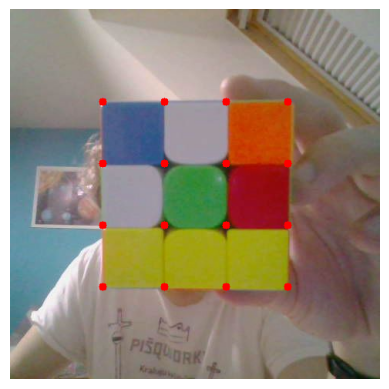

<IPython.core.display.Javascript object>

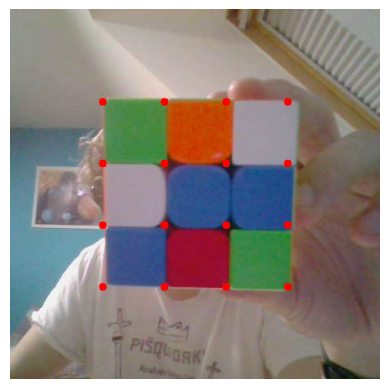

<IPython.core.display.Javascript object>

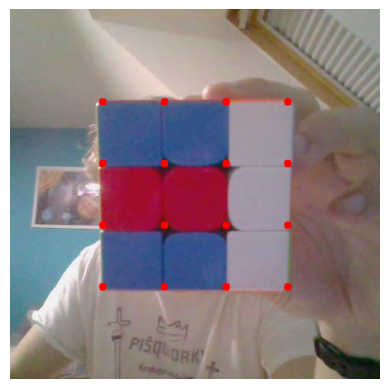

<IPython.core.display.Javascript object>

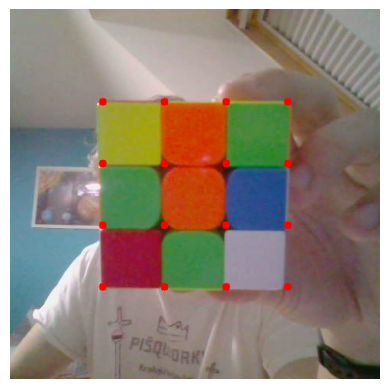

In [ ]:
cube = []

for i in range(6):
    image = take_photo()

    # Z√≠sk√°n√≠ kl√≠ƒçov√Ωch bod≈Ø
    grid_points = get_grid_points(image)
    show_grid_points(grid_points)

    # Matice barev
    colors_matrix = get_colors_matrix(image)
    text_matrix = get_text_matrix(colors_matrix, average_hue_arr, average_saturation_arr, average_value_arr)

    cube.append(text_matrix)

# Kontrola cel√© kostky a jej√≠ reprezentace
> Pozn√°mka: Nutno podotknout, ≈æe pokud bychom chtƒõli reprezentaci p≈ôev√©st do 3D, museli bychom se dr≈æet urƒçit√Ωch konvenc√≠ p≈ôi skenov√°n√≠.

In [ ]:
# Kontrola, jestli je kostka slo≈æen√°
solved = all(is_solved_side(side) for side in cube)

if solved:
    print("üü© Kostka je slo≈æen√°!\n")
else:
    print("üü• Kostka nen√≠ slo≈æen√°.\n")

# Reprezentace kostky
for i, side in enumerate(cube):
    print(f"Strana {i+1}:")
    for row in side:
        print(row)
    print()

üü• Kostka nen√≠ slo≈æen√°.

Strana 1:
['red' 'green' 'yellow']
['red' 'white' 'yellow']
['orange' 'orange' 'red']

Strana 2:
['red' 'green' 'orange']
['yellow' 'yellow' 'orange']
['green' 'yellow' 'orange']

Strana 3:
['blue' 'white' 'orange']
['white' 'green' 'red']
['yellow' 'yellow' 'yellow']

Strana 4:
['green' 'orange' 'white']
['white' 'blue' 'blue']
['blue' 'red' 'green']

Strana 5:
['blue' 'blue' 'white']
['red' 'red' 'white']
['blue' 'blue' 'white']

Strana 6:
['yellow' 'orange' 'green']
['green' 'orange' 'blue']
['red' 'green' 'white']



# Uk√°zkov√Ω p≈ô√≠klad vyhodnocen√≠ na z√°kladƒõ vstup≈Ø

## Slo≈æen√° kostka
<p align="left">
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/white.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/yellow.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/green.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/blue.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/red.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/orange.png?raw=true" width="200"/>
</p>


Strana 1:
['white' 'white' 'white']
['white' 'white' 'white']
['white' 'white' 'white']

Strana 2:
['yellow' 'yellow' 'yellow']
['yellow' 'yellow' 'yellow']
['yellow' 'yellow' 'yellow']

Strana 3:
['green' 'green' 'green']
['green' 'green' 'green']
['green' 'green' 'green']

Strana 4:
['blue' 'blue' 'blue']
['blue' 'blue' 'blue']
['blue' 'blue' 'blue']

Strana 5:
['red' 'red' 'red']
['red' 'red' 'red']
['red' 'red' 'red']

Strana 6:
['orange' 'orange' 'orange']
['orange' 'orange' 'orange']
['orange' 'orange' 'orange']


## Neslo≈æen√° kostka
<p align="left">
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/unsolved_white.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/unsolved_yellow.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/unsolved_green.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/unsolved_blue.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/unsolved_red.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/unsolved_orange.png?raw=true" width="200"/>
</p>


üü• Kostka nen√≠ slo≈æen√°.

Strana 1:
['red' 'green' 'yellow']
['red' 'white' 'yellow']
['orange' 'orange' 'red']

Strana 2:
['red' 'green' 'orange']
['yellow' 'yellow' 'orange']
['green' 'yellow' 'orange']

Strana 3:
['blue' 'white' 'orange']
['white' 'green' 'red']
['yellow' 'yellow' 'yellow']

Strana 4:
['green' 'orange' 'white']
['white' 'blue' 'blue']
['blue' 'red' 'green']

Strana 5:
['blue' 'blue' 'white']
['red' 'red' 'white']
['blue' 'blue' 'white']

Strana 6:
['yellow' 'orange' 'green']
['green' 'orange' 'blue']
['red' 'green' 'white']